In [110]:
# Importando Bibliotecas
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [111]:
# Carregando datasets de treino e teste
houses_train = pd.read_csv('/home/satire/PycharmProjects/Statistics/csv/train.csv')
houses_test = pd.read_csv('/home/satire/PycharmProjects/Statistics/csv/test.csv')
print(f"Houses train: {houses_train.shape}")
print(f"Houses test: {houses_test.shape}")

Houses train: (1460, 81)
Houses test: (1459, 80)


In [112]:
# Verificando duplicidade
duplicate_train = houses_train[houses_train.duplicated('Id')]
print(f"Duplicate train: {len(duplicate_train)}")
duplicate_test = houses_test[houses_test.duplicated('Id')]
print(f"Duplicate test: {len(duplicate_test)}")

Duplicate train: 0
Duplicate test: 0


In [113]:
# Avaliação da coluna target
houses_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

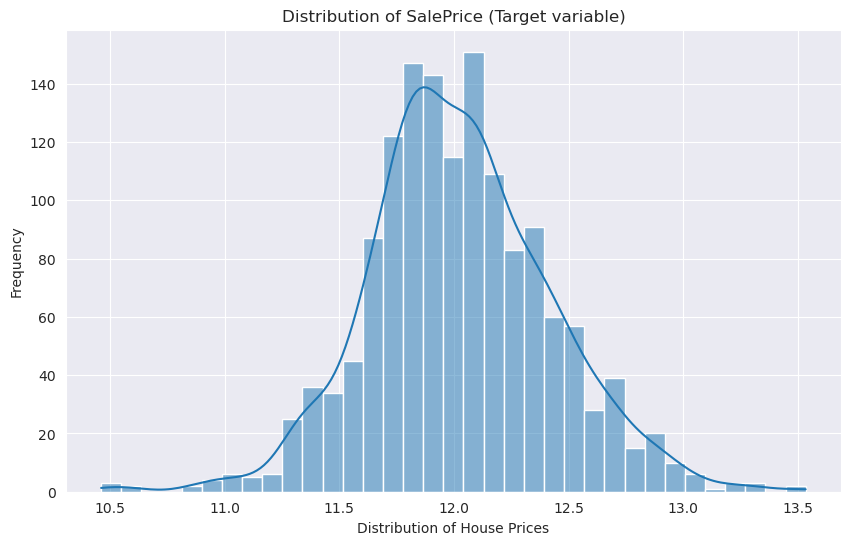

Skewness: 0.121335
Kurtosis: 0.809532


In [114]:
# Usando transformação com log devido a calda da distribuição ser inclinada para a direita
houses_train['SalePrice'] = np.log(houses_train['SalePrice'])
plt.figure(figsize=(10, 6))
sns.histplot(data=houses_train, x="SalePrice",  kde=True)
plt.title('Distribution of SalePrice (Target variable)')
plt.xlabel('Distribution of House Prices')
plt.ylabel('Frequency')
plt.show()
# Avaliação se houve diferença após a transformação
print("Skewness: %f" % houses_train['SalePrice'].skew())
print("Kurtosis: %f" % houses_train['SalePrice'].kurt())

In [115]:
# Função para retirar a coluna de Id
def drop_id(df):
    df = df.drop('Id', axis=1)
    return df

In [116]:
# Aplicando a seguinte função
houses_train = drop_id(houses_train)
houses_test = drop_id(houses_test)

In [117]:
# Separando colunas númericas
def separate_numerical(data):
    return list(data.select_dtypes(include=np.number).columns)

In [118]:
# Verificação para tipo de classe
numerical_train = separate_numerical(houses_train)
numerical_test = separate_numerical(houses_test)
print(type(numerical_train))
print(type(numerical_test))

<class 'list'>
<class 'list'>


MSSubClass
Skew : 1.41


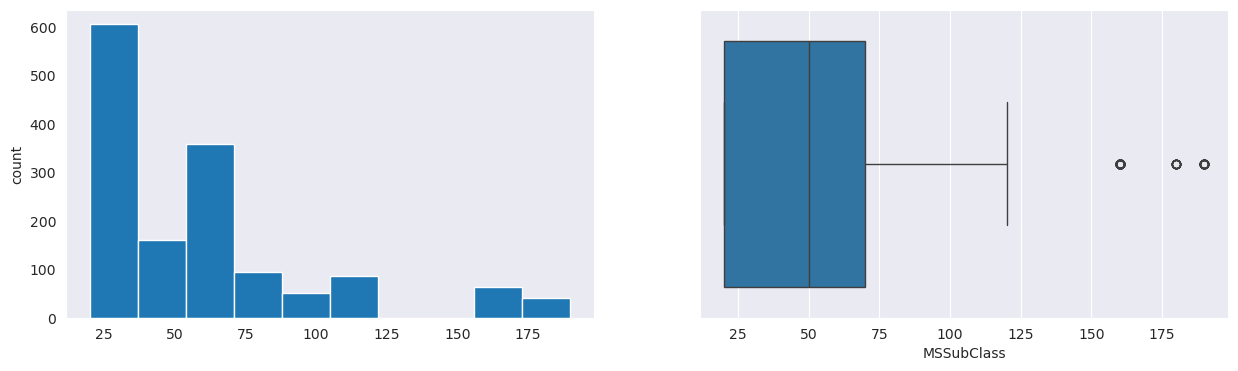

LotFrontage
Skew : 2.16


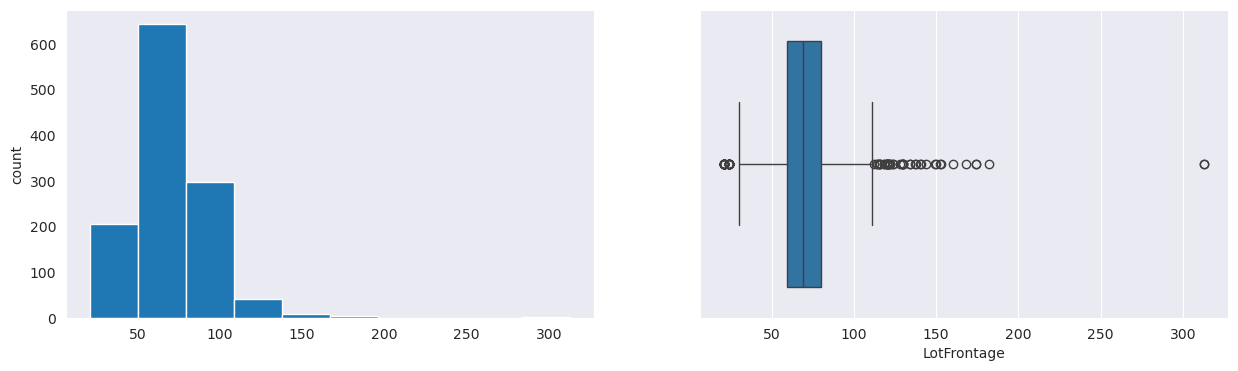

LotArea
Skew : 12.21


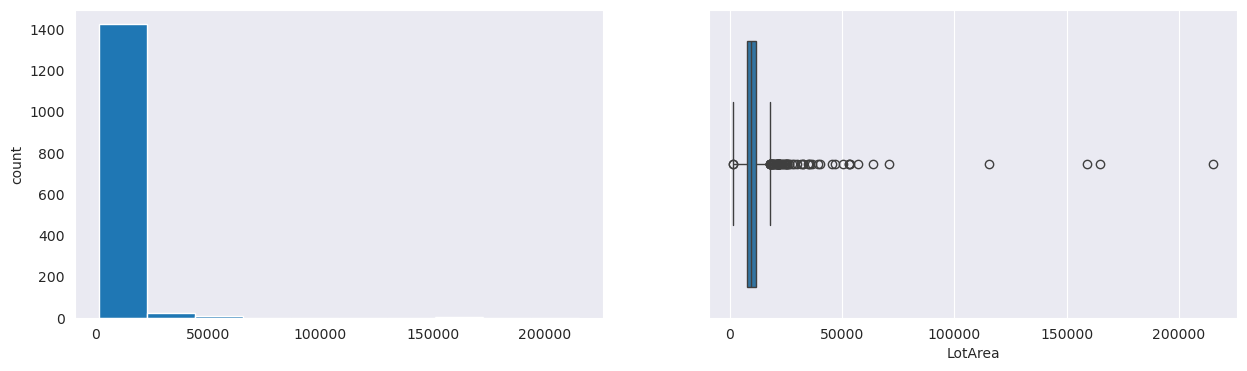

OverallQual
Skew : 0.22


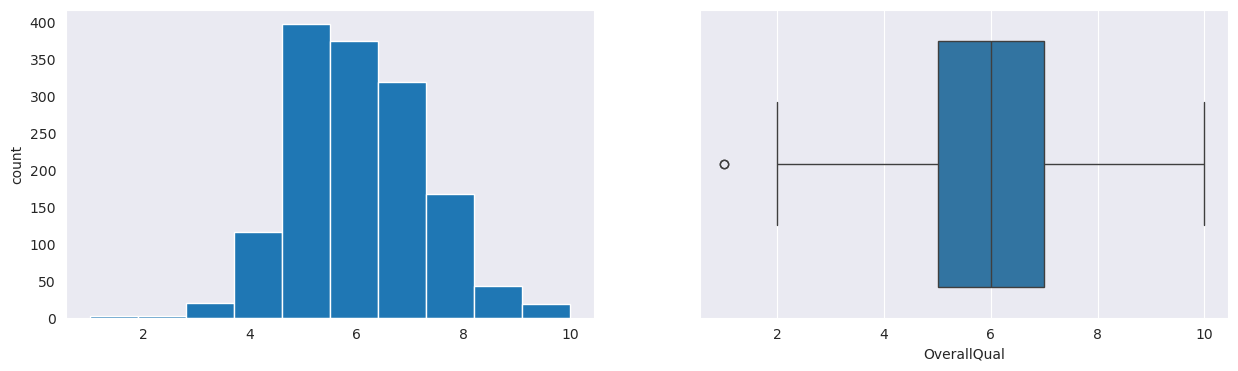

OverallCond
Skew : 0.69


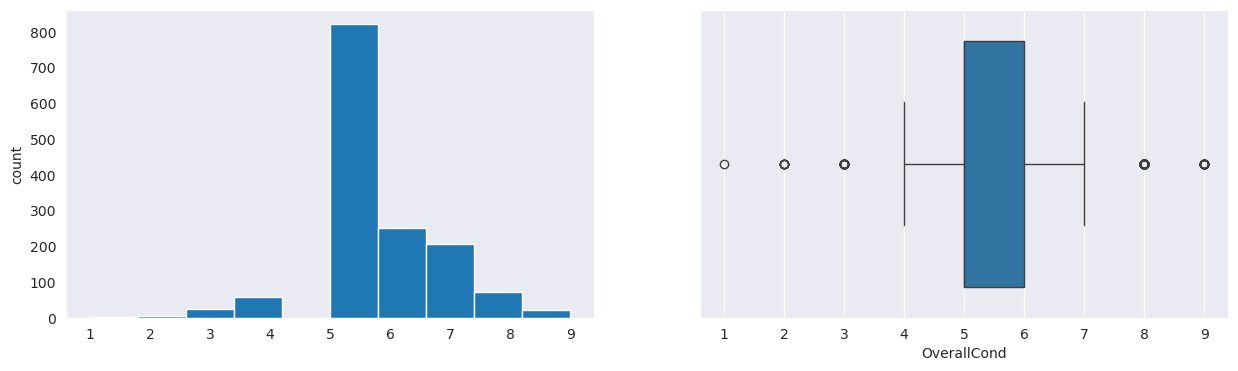

YearBuilt
Skew : -0.61


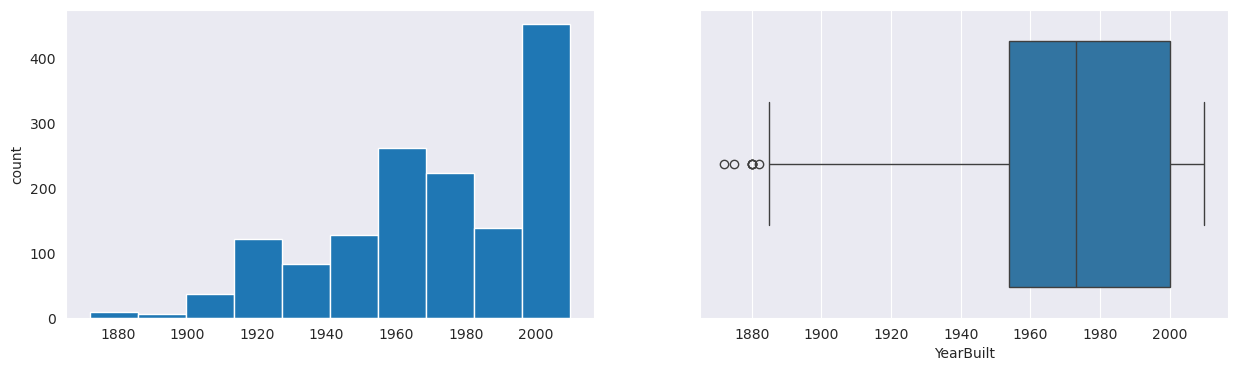

YearRemodAdd
Skew : -0.5


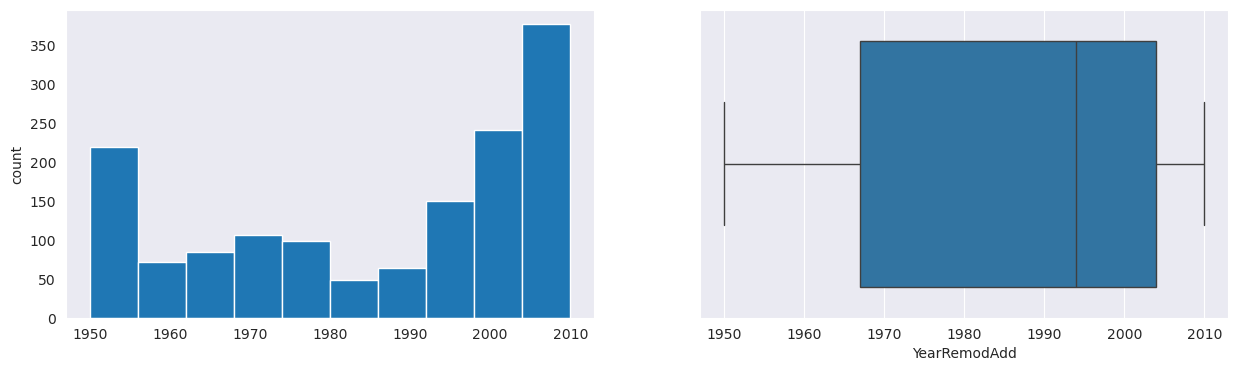

MasVnrArea
Skew : 2.67


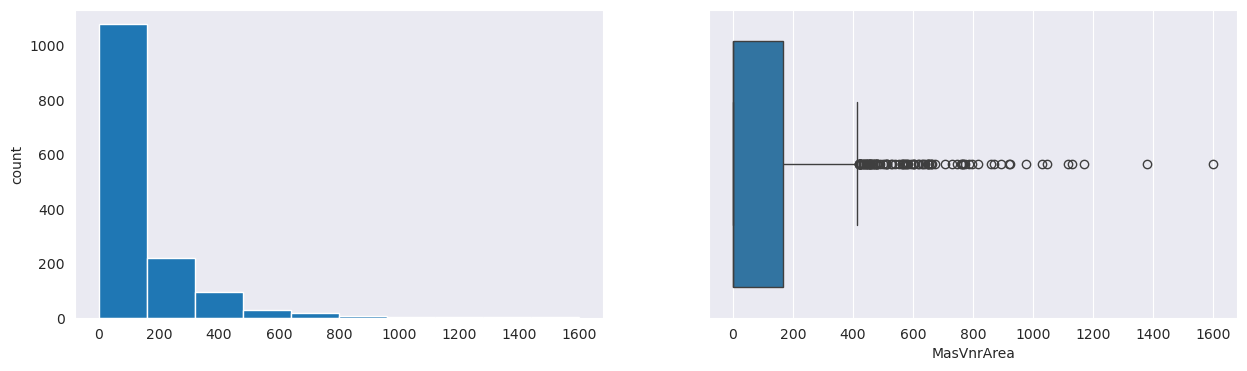

BsmtFinSF1
Skew : 1.69


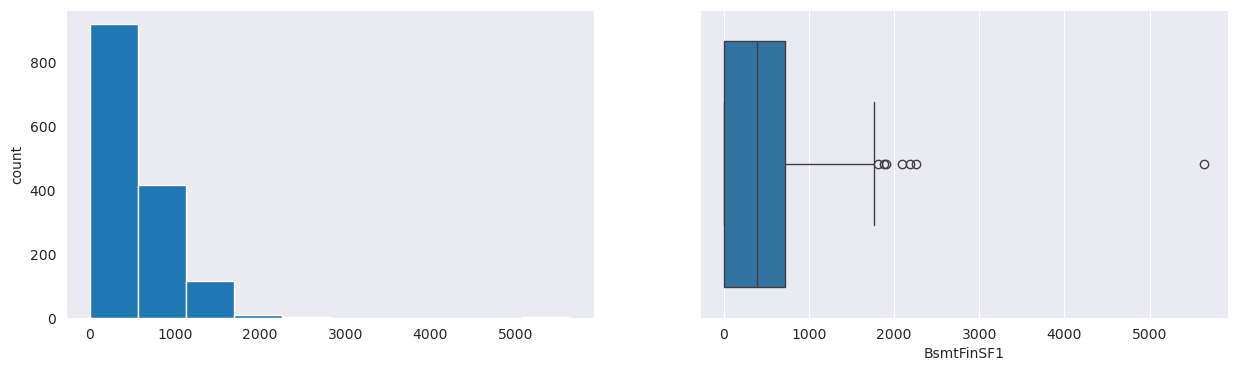

BsmtFinSF2
Skew : 4.26


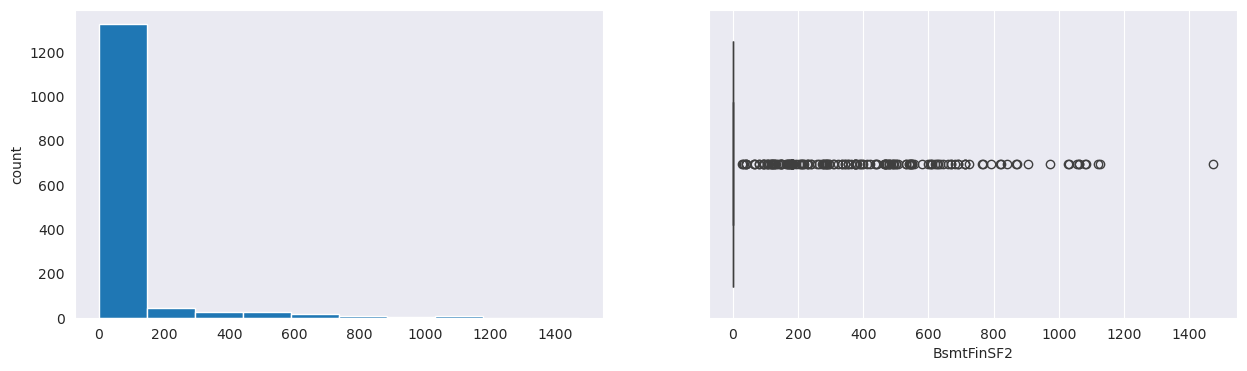

BsmtUnfSF
Skew : 0.92


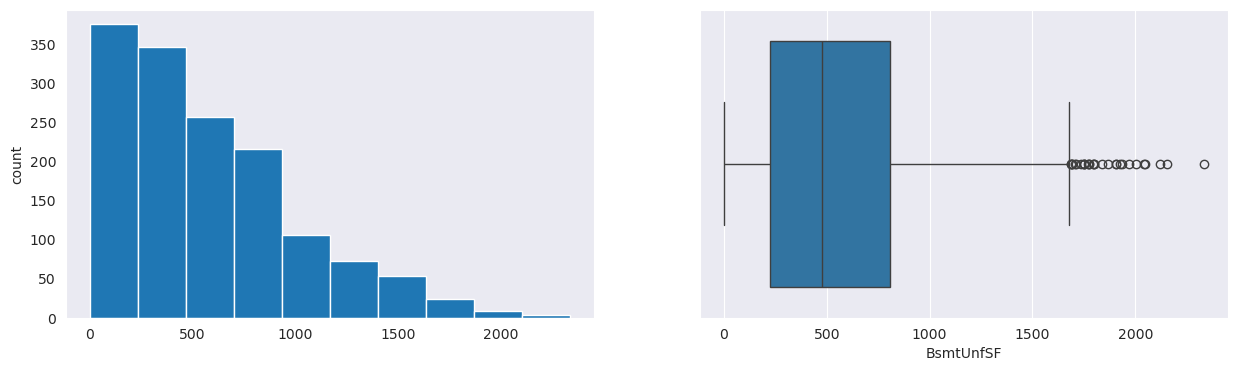

TotalBsmtSF
Skew : 1.52


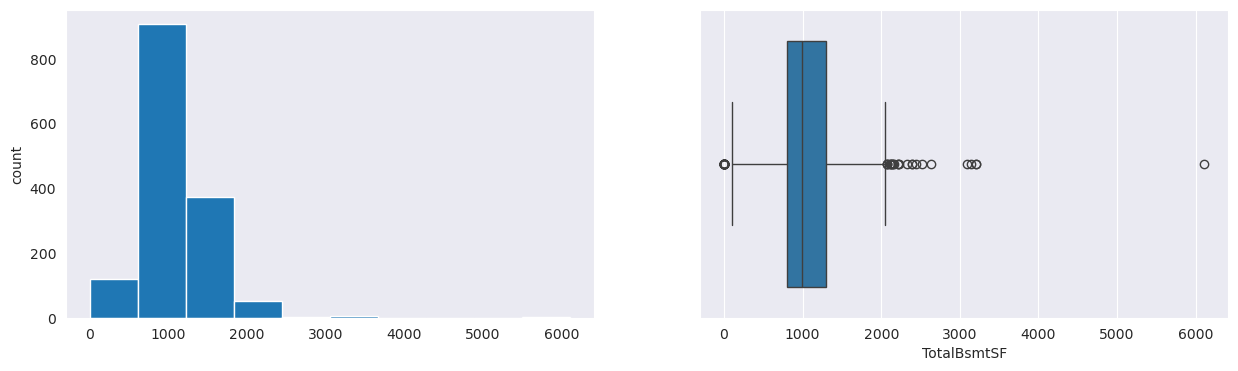

1stFlrSF
Skew : 1.38


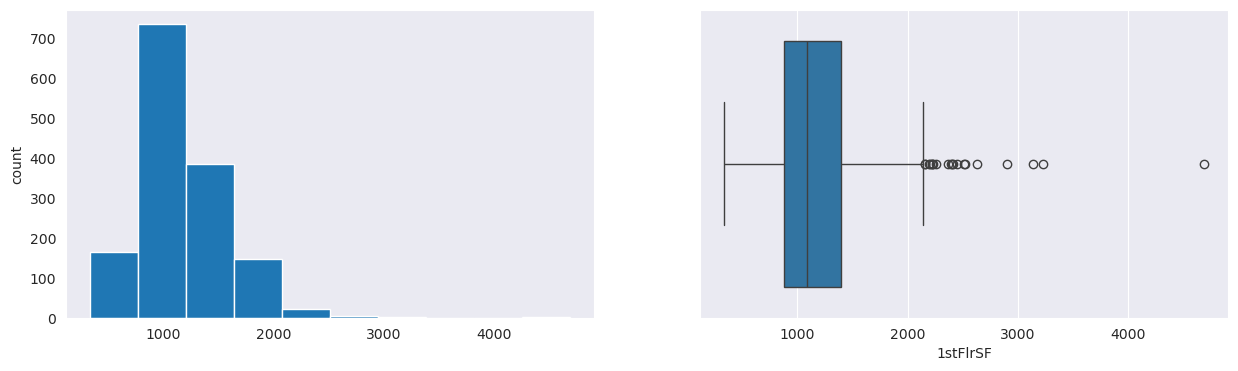

2ndFlrSF
Skew : 0.81


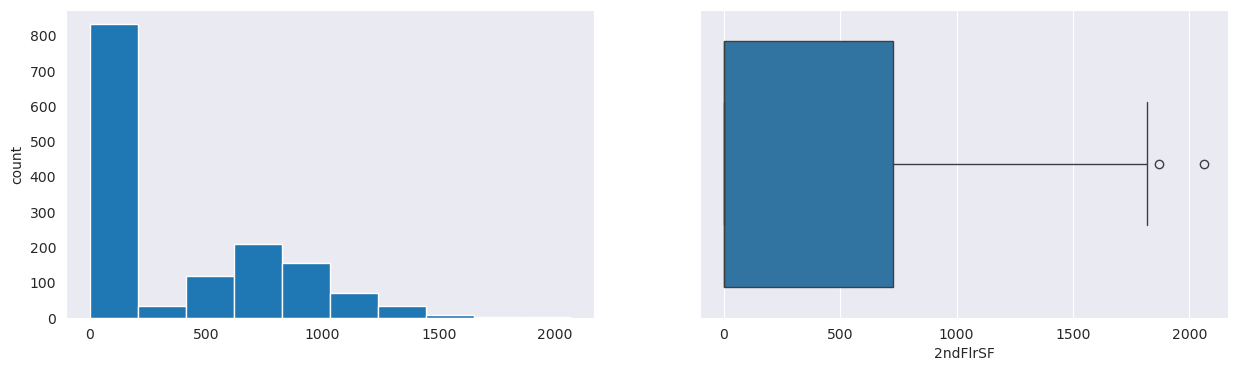

LowQualFinSF
Skew : 9.01


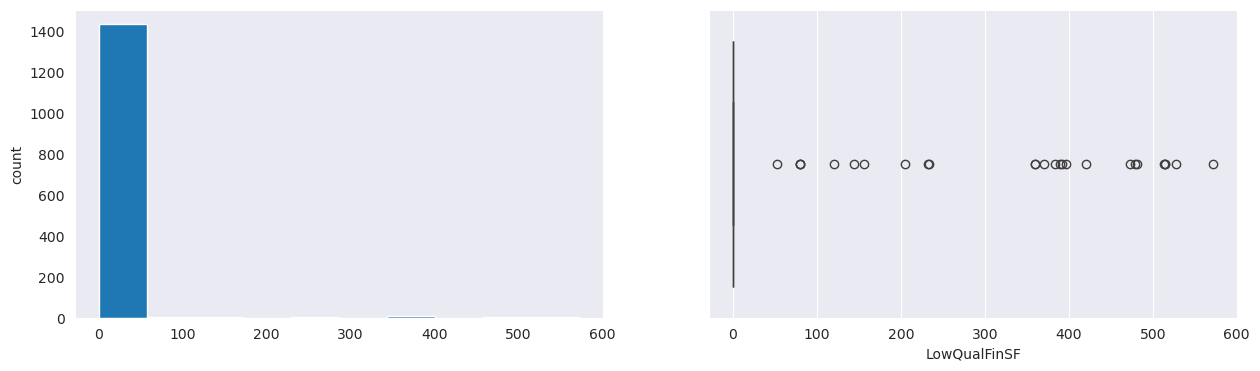

GrLivArea
Skew : 1.37


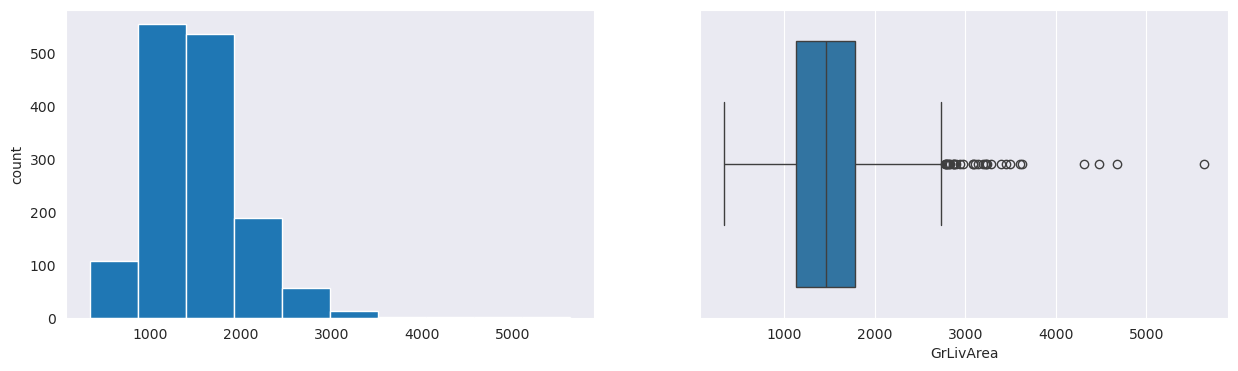

BsmtFullBath
Skew : 0.6


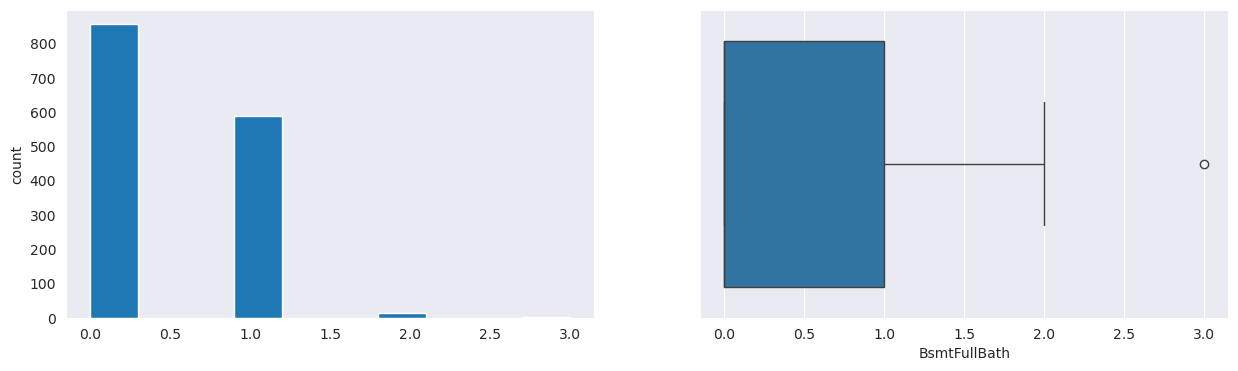

BsmtHalfBath
Skew : 4.1


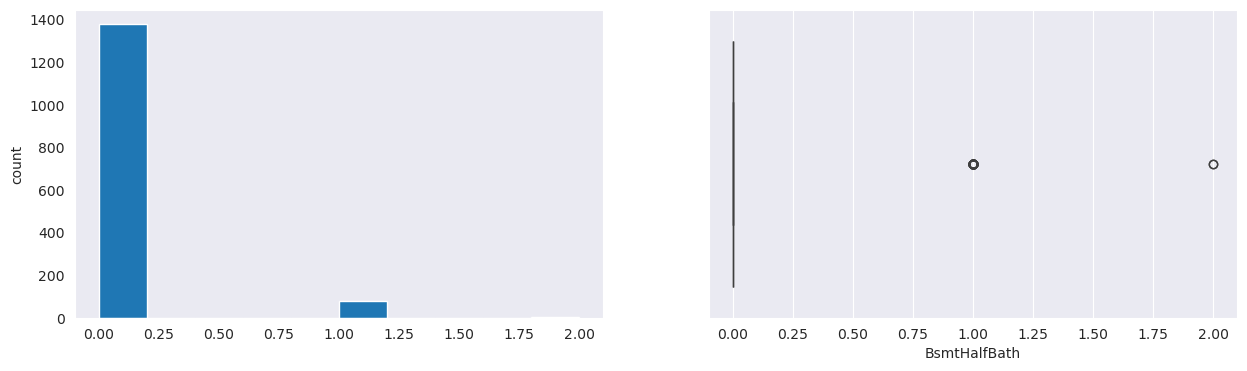

FullBath
Skew : 0.04


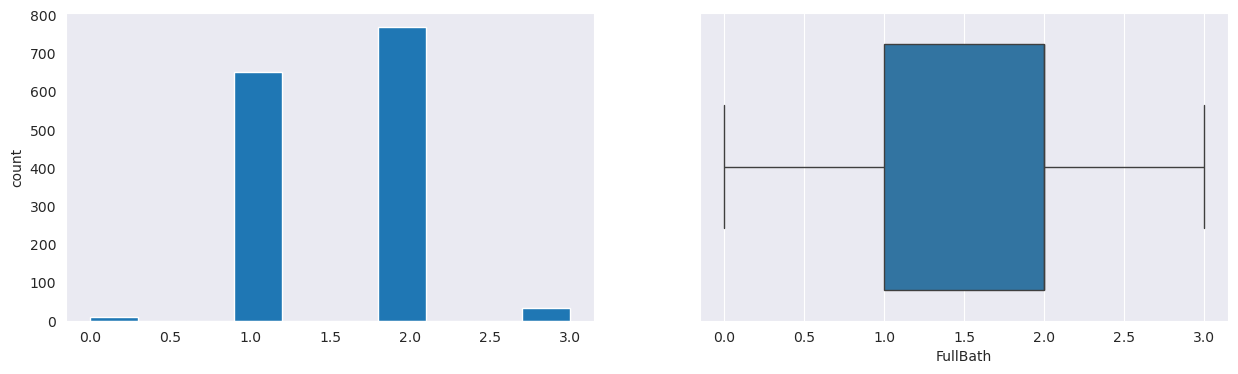

HalfBath
Skew : 0.68


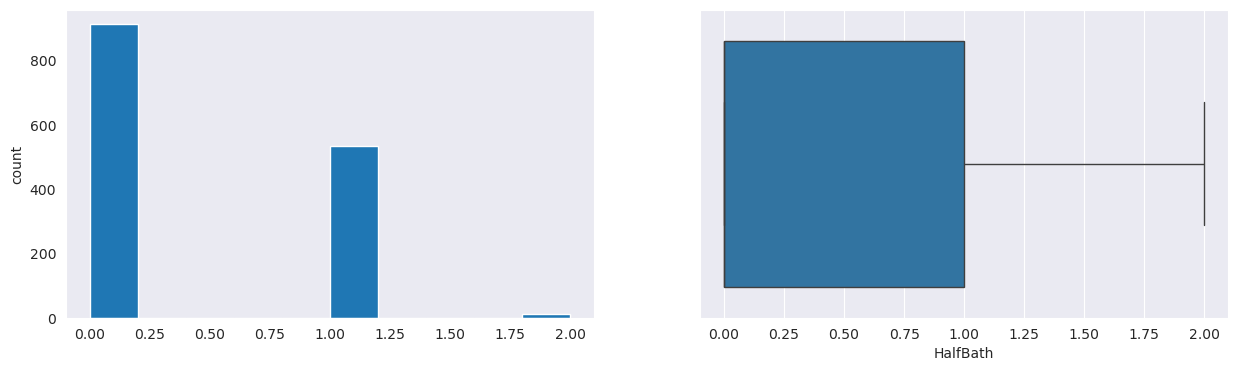

BedroomAbvGr
Skew : 0.21


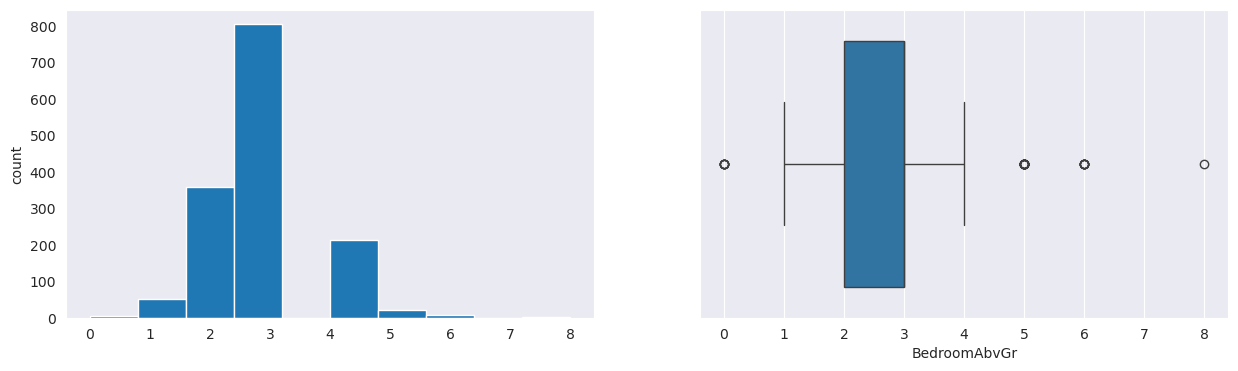

KitchenAbvGr
Skew : 4.49


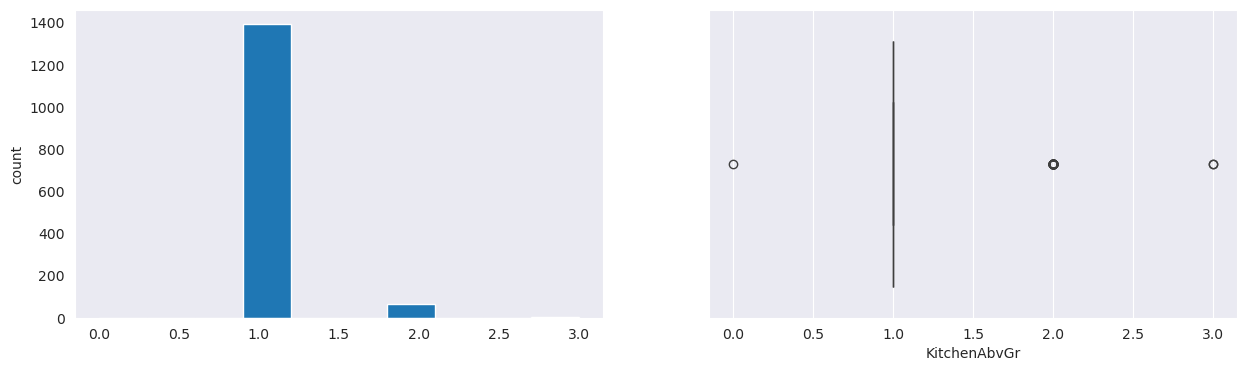

TotRmsAbvGrd
Skew : 0.68


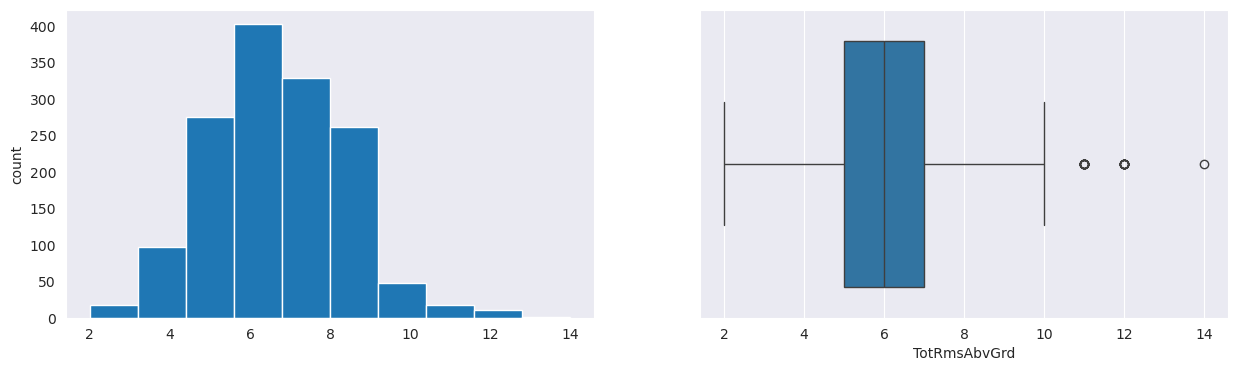

Fireplaces
Skew : 0.65


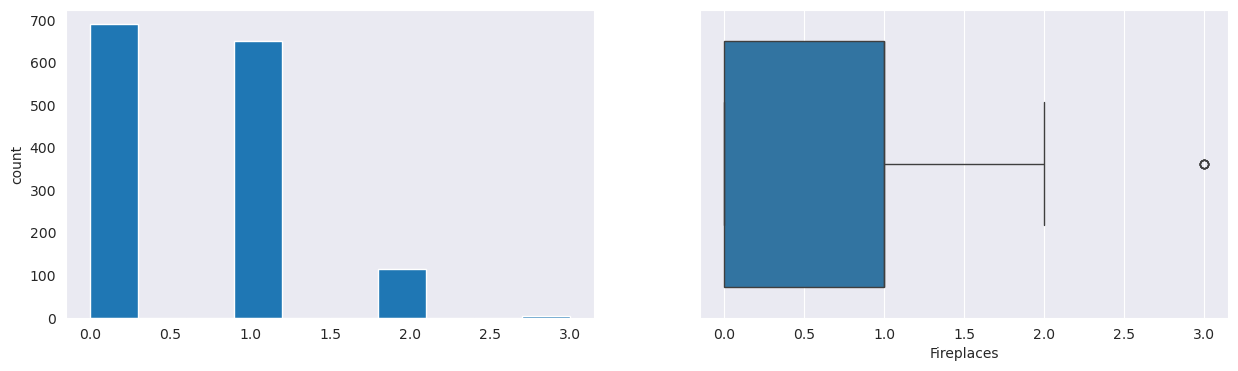

GarageYrBlt
Skew : -0.65


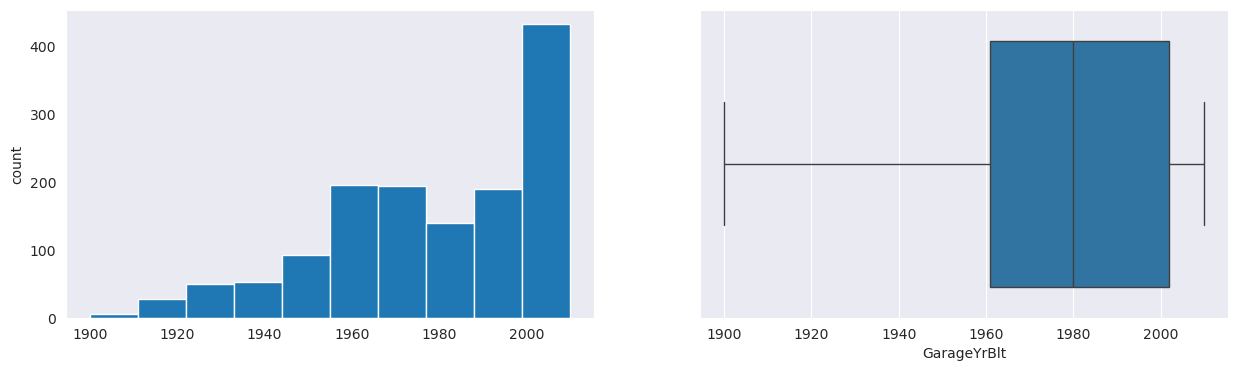

GarageCars
Skew : -0.34


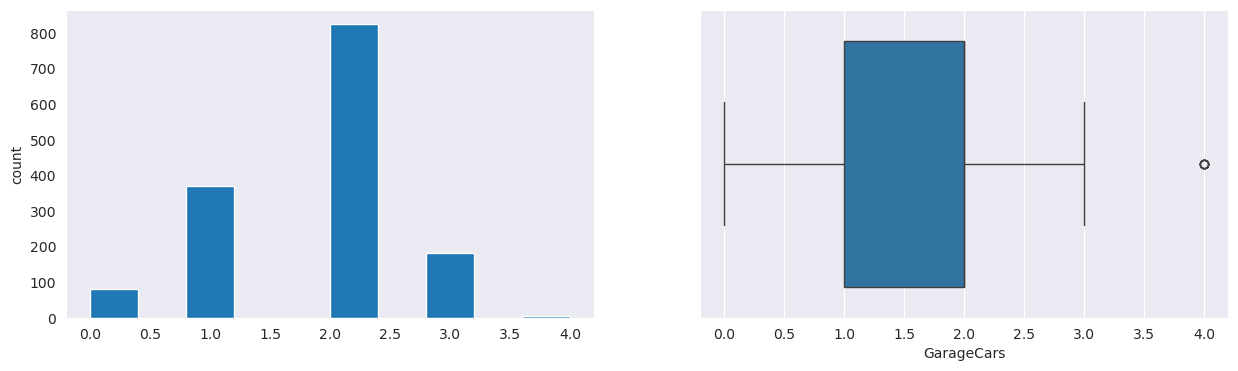

GarageArea
Skew : 0.18


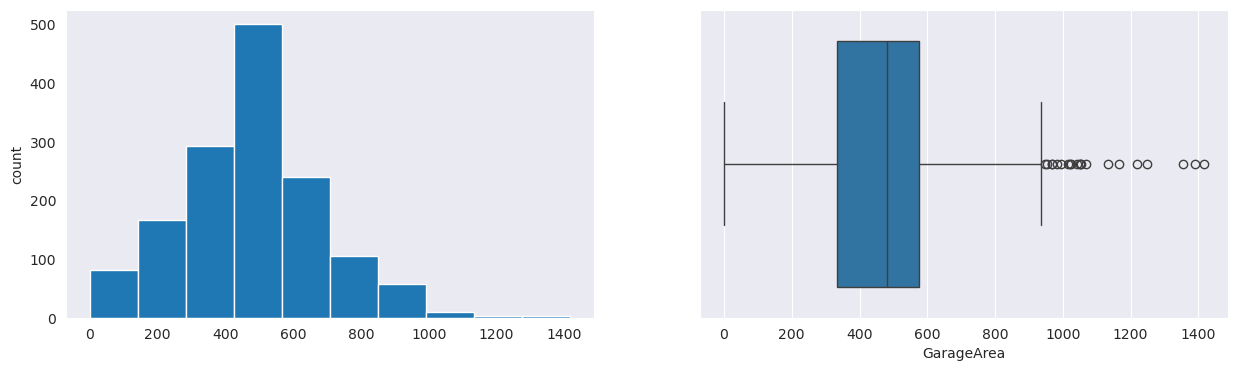

WoodDeckSF
Skew : 1.54


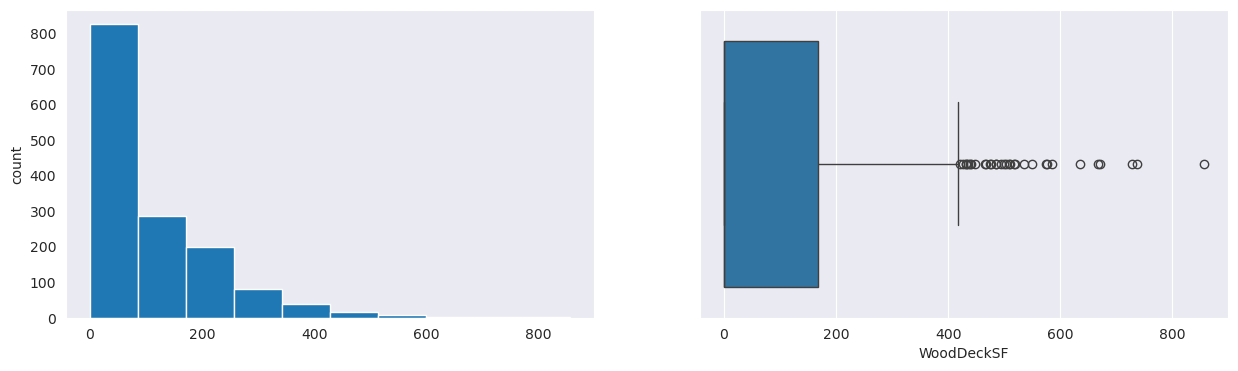

OpenPorchSF
Skew : 2.36


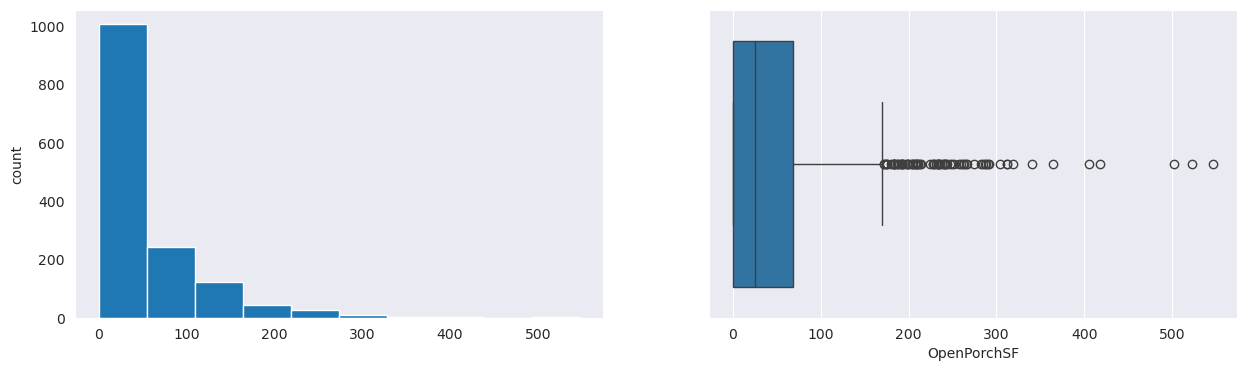

EnclosedPorch
Skew : 3.09


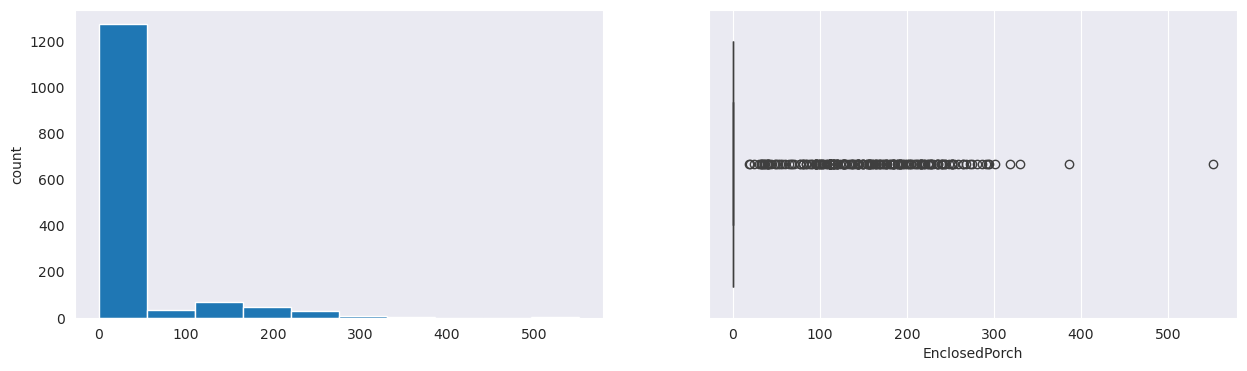

3SsnPorch
Skew : 10.3


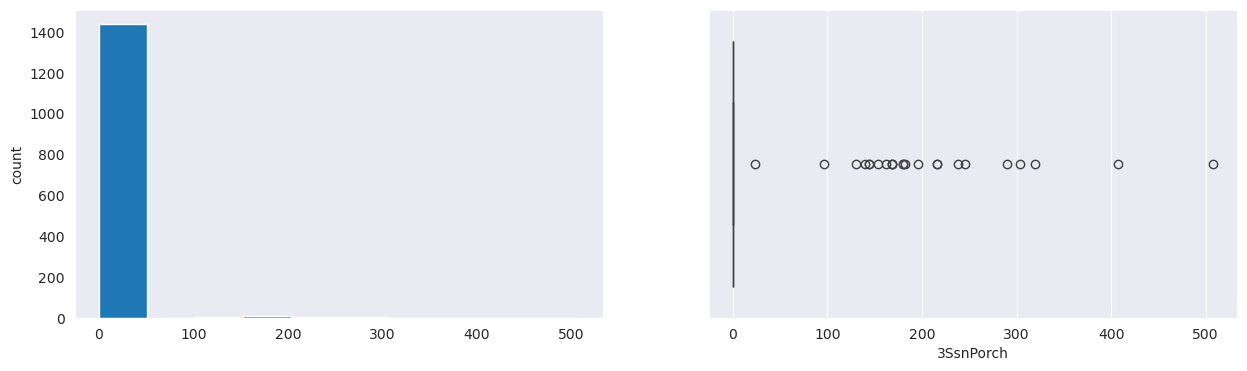

ScreenPorch
Skew : 4.12


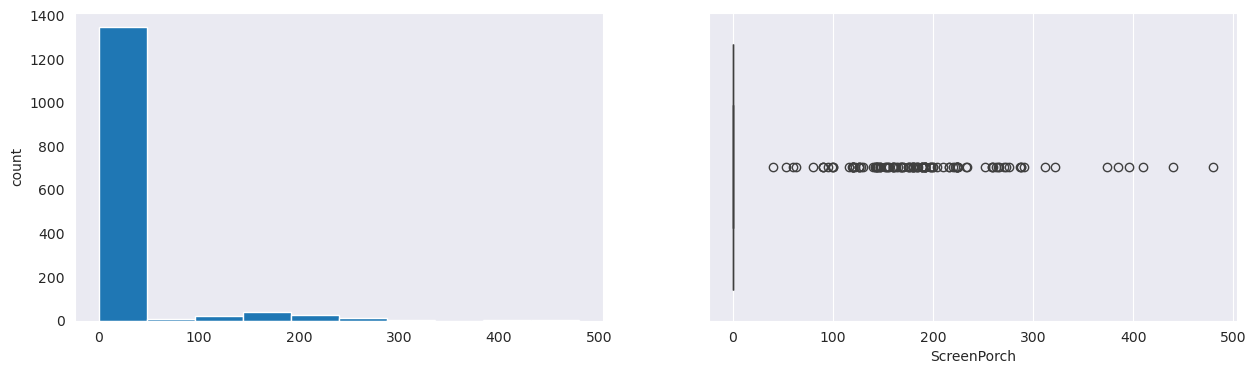

PoolArea
Skew : 14.83


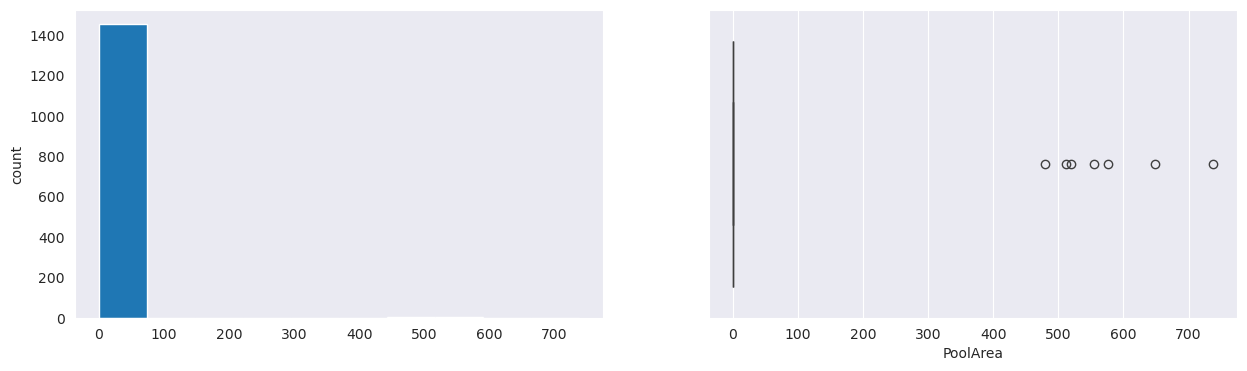

MiscVal
Skew : 24.48


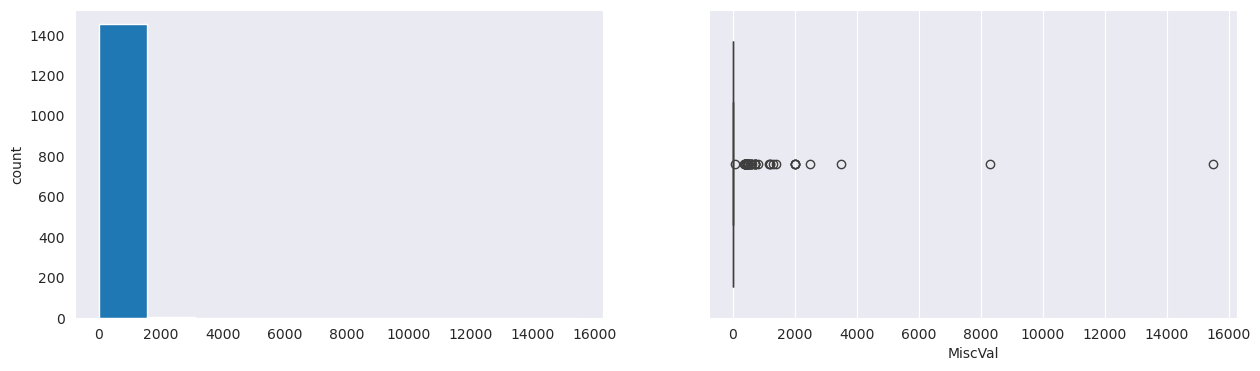

MoSold
Skew : 0.21


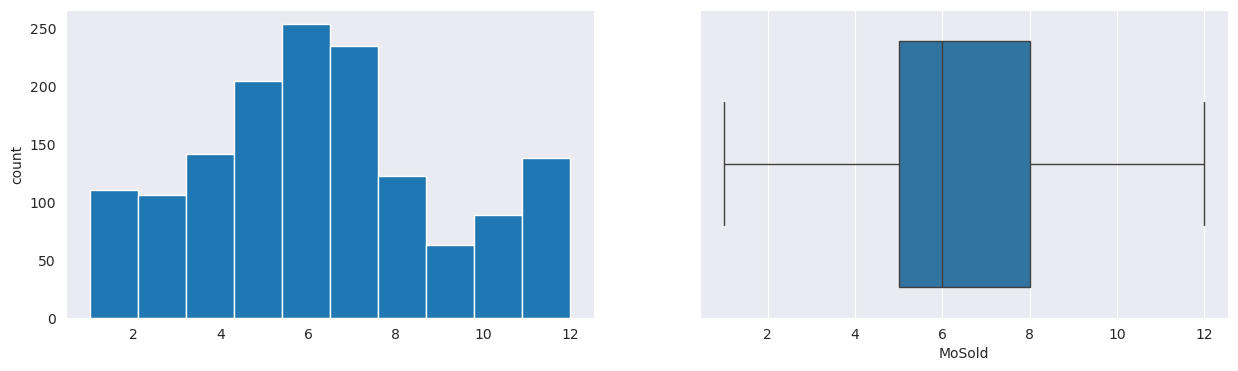

YrSold
Skew : 0.1


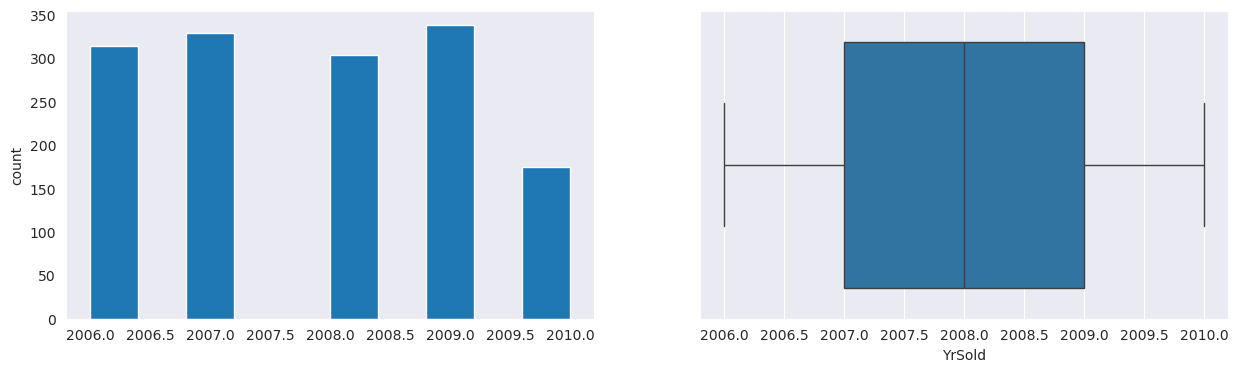

SalePrice
Skew : 0.12


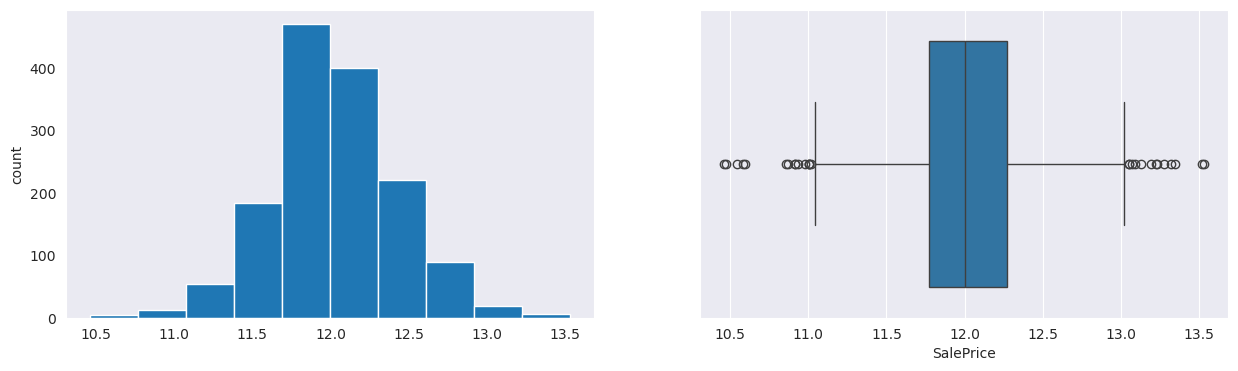

In [119]:
# Função para verificar  a distribuição das colunas através de Análise exploratória
for col in numerical_train:
    print(col)
    print('Skew :', round(houses_train[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    houses_train[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=houses_train[col])
    plt.show()

In [120]:
# Concatenando dados de treino e teste para que faça as transformações apenas uma vez
df = pd.concat([houses_train, houses_test])
df.reset_index(drop=True, inplace=True)
df.shape

(2919, 80)

In [121]:
# Verificando quantidade de nulos
df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
dtype: int64

In [122]:
# Separando variáveis categóricas e numéricas exceto a variável target
def separate_variables(data):
    cat_cols = list(data.select_dtypes(include=['object']).columns)
    num_cols = [col for col in data.select_dtypes(include=np.number).columns if col != 'SalePrice']
    return cat_cols, num_cols

In [123]:
# Substituindo as variáveis nulas categóricas pela moda
def impute_categorical_columns(df, cat_cols):
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
    return df

In [124]:
# Substituindo as variáveis categŕocas nulas pela média através dos 3 vizinhos mais próximos
def impute_numerical_columns(df, num_cols, n_neighbors=3, decimals=0):
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df[num_cols] = knn_imputer.fit_transform(df[num_cols])
    df[num_cols] = df[num_cols].round(decimals)
    return df

In [125]:
# Aplicação da primeira função
cat_cols, num_cols = separate_variables(df)

In [126]:
# Aplicação das seguintes funções
df = impute_categorical_columns(df, cat_cols)
df = impute_numerical_columns(df, num_cols, n_neighbors=3)

In [127]:
# Engenharia de feature para as colunas relacionadas a garagem

# Usando a idade da garagem
df['GarageYrBlt'] = df['YrSold'] - df['GarageYrBlt']

# Usando a idade da casa
df['YearBuilt'] = df['YrSold'] - df['YearBuilt']

# Idade de remodelação da casa
df['YearRemodAdd'] = df['YrSold'] - df['YearRemodAdd']

df.drop(['YrSold', 'GarageYrBlt'], axis=1, inplace=True)

In [128]:
# Somando o primeiro andar mais o segundo para uma única variável
df['BsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['TotalFlrSF'] = df['1stFlrSF'] + df['2ndFlrSF']

df.drop(['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

In [129]:
# Somando quantidade dos banheiros da casa mais sua metade
df['TotalBaths'] = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])

df.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)

In [130]:
# Cálculo da área da garagem por carro em uma única variável
df['GarageAreaPerCar'] = df['GarageArea'] / df['GarageCars']

df['GarageAreaPerCar'] = df['GarageAreaPerCar'].fillna(0)

df.drop(['GarageArea', 'GarageCars'], axis=1, inplace=True)

In [131]:
# Seleção de variáveis numéricas
numerical_cols = separate_numerical(df)

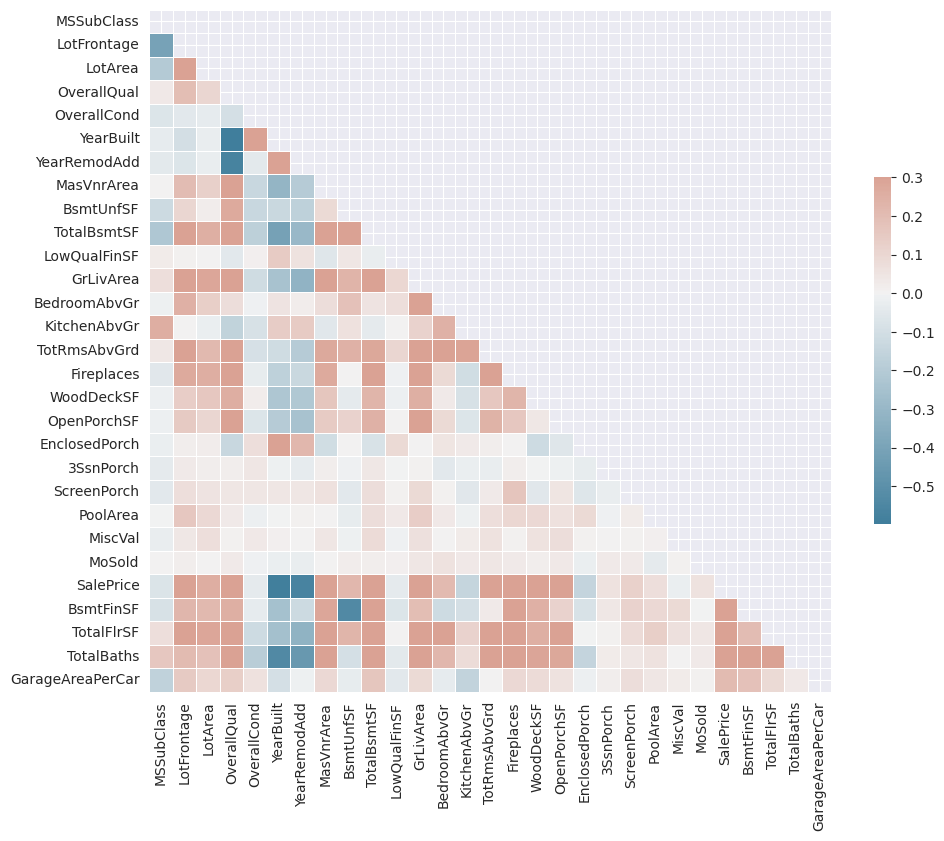

In [132]:
# Correlação dessas variáveis com Saleprice
corr = df[numerical_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [133]:
# Remoção dos nulos na variável Saleprice devido a concatenação dos datasets
df = df.dropna()

In [134]:
print(df.isnull().sum())

MSSubClass          0
MSZoning            0
LotFrontage         0
LotArea             0
Street              0
                   ..
SalePrice           0
BsmtFinSF           0
TotalFlrSF          0
TotalBaths          0
GarageAreaPerCar    0
Length: 72, dtype: int64


In [135]:
# Seleção de features e targets usadas
X = df[['LotFrontage', 'LotArea', 'OverallQual', 'MasVnrArea', 'BsmtUnfSF',
        'TotalBsmtSF', 'GrLivArea', 'BedroomAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'BsmtFinSF', 'TotalFlrSF']]
y = df['SalePrice']

In [136]:
# padronização dos valores das variáveis independentes
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [137]:
# Separação entre treino e teste e modelo de regressão linear
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 0.02973656674953793
R-squared: 0.8406515935783587
